# **<font color=white> 08.Robust Random Cut Forest Code 실습**

[목적]
  - Robust Random Cut Forest Code 실습
  - Multivariate variable (다변량)일 때 사용
  - 각 Data마다 Score를 계산하여 Abnormal을 산출 할 수 있음
  
[Process]
  1. Define Data
  2. Modeling
  3. Plotting

In [1]:
%pip install pyod
%pip install rrcf

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rrcf: filename=rrcf-0.4.4-py3-none-any.whl size=10611 sha256=659f36890e6922ca3a50c7284f3d95a44d3a0f598623d59d79928c75f65fa67f
  Stored in directory: c:\users\soo.y\appdata\local\pip\cache\wheels\46\5f\a8\4ae602057e8487bc3f03d4ca80cbe04d97d2f5b292131afcad
Successfully built rrcf
Note: you may need to restart the kernel to use updated packages.


In [2]:
import rrcf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pyod.utils.data import generate_data, get_outliers_inliers

In [3]:
# Data Loading
X, Y = generate_data(behaviour='new', n_features=10, 
                     train_only=True,
                     contamination=0.1,
                     random_state=2023)

In [4]:
# Naming for columns
col_list = []
for i in range(X.shape[1]):
    a = 'X{}'.format(i+1)
    col_list.append(a)

In [5]:
# Columns Name
col_list

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']

In [6]:
# Make DF
df = pd.DataFrame(X, columns = col_list)
df['Y'] = Y

In [7]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,8.147125,6.595282,6.353558,6.653506,8.134808,7.426514,6.474067,7.230509,7.457418,6.916700,0.0
1,6.872178,6.596448,7.349710,7.097543,7.024347,6.615302,6.753538,7.218030,7.819604,6.563562,0.0
2,6.910465,5.856827,6.495701,6.598612,8.042650,6.205240,7.024534,6.822316,7.475852,7.106808,0.0
3,6.901166,6.942458,6.354764,6.447391,6.595218,7.941335,6.104982,6.930397,8.076817,7.715245,0.0
4,7.465372,6.305800,7.858624,6.456638,7.610647,6.530033,7.509274,7.636209,7.650121,7.043726,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.018529,5.163813,5.468692,-2.640285,-0.578817,1.487439,2.359938,-6.462774,2.466932,1.323520,1.0
996,3.328107,0.614357,5.886779,6.717434,2.906959,-6.980421,2.245124,-2.790132,-4.169568,0.832299,1.0
997,4.516967,-5.648011,-5.330594,-6.352683,-1.796092,5.129173,3.517025,-0.234736,1.941775,5.095802,1.0
998,2.223976,-4.295404,2.192168,1.202558,5.348682,3.638888,5.204538,2.540078,-5.530535,5.884657,1.0


Text(0.5, 1.0, 'Ground Truth')

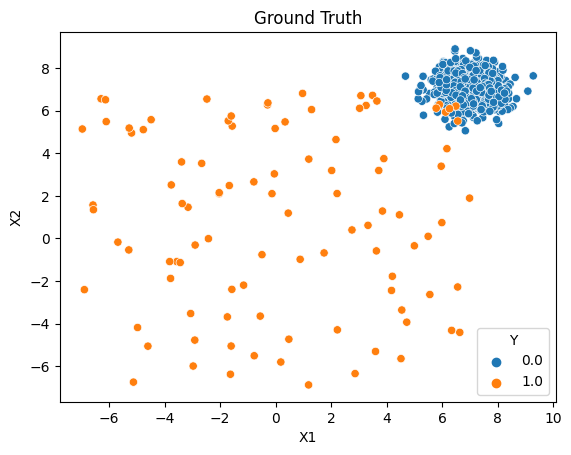

In [8]:
# Data 분포 확인하기 X1, X2
sns.scatterplot(x='X1', y='X2', hue='Y', data=df);
plt.title('Ground Truth')

[Robust Random Cut Forest Parameter]
  - Introduction page : https://klabum.github.io/rrcf/
  - Code gitgub : https://github.com/kLabUM/rrcf
  - rrcf는 특이하게 parameter를 Code로 짜줘야함...

In [9]:
df_array = np.array(df)

# Set parameters
num_trees = 150
tree_size = 500

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(df_array.shape[0], size=(df_array.shape[0] // tree_size, tree_size),
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(df_array[ix, :2], index_labels=ix) for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(df_array.shape[0]))
index = np.zeros(df_array.shape[0])
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [10]:
avg_codisp

0       7.570690
1       3.437957
2      10.851598
3       4.120148
4       4.049982
         ...    
995    19.511323
996    22.000839
997    46.023377
998    23.472008
999    19.868637
Length: 1000, dtype: float64

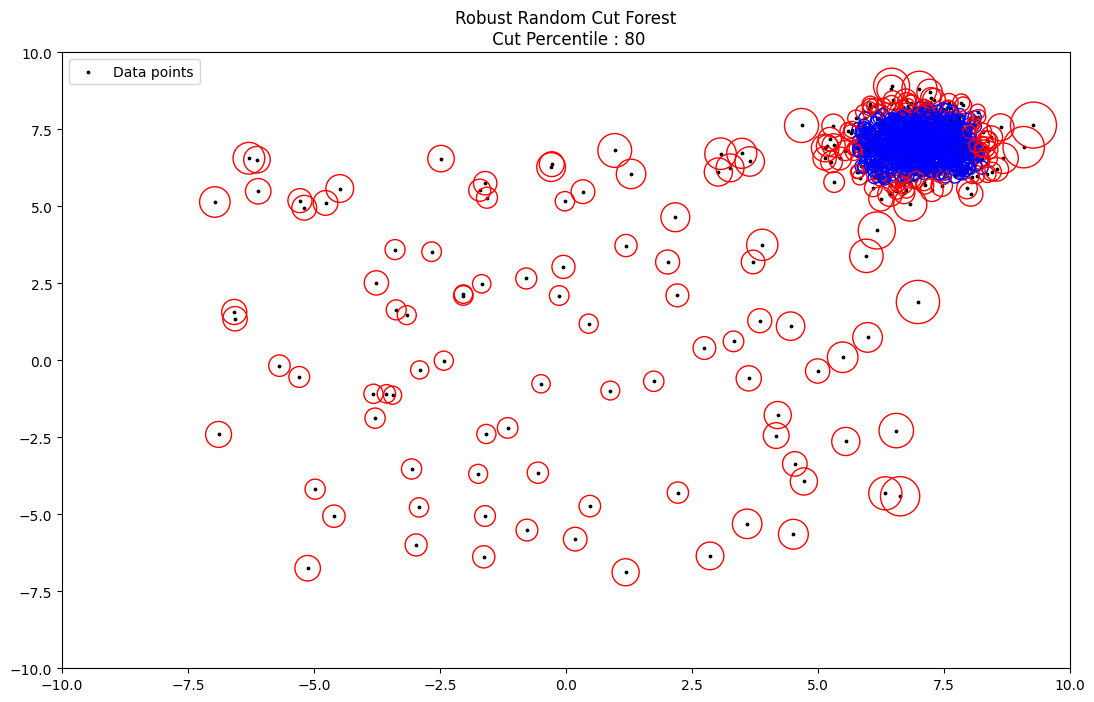

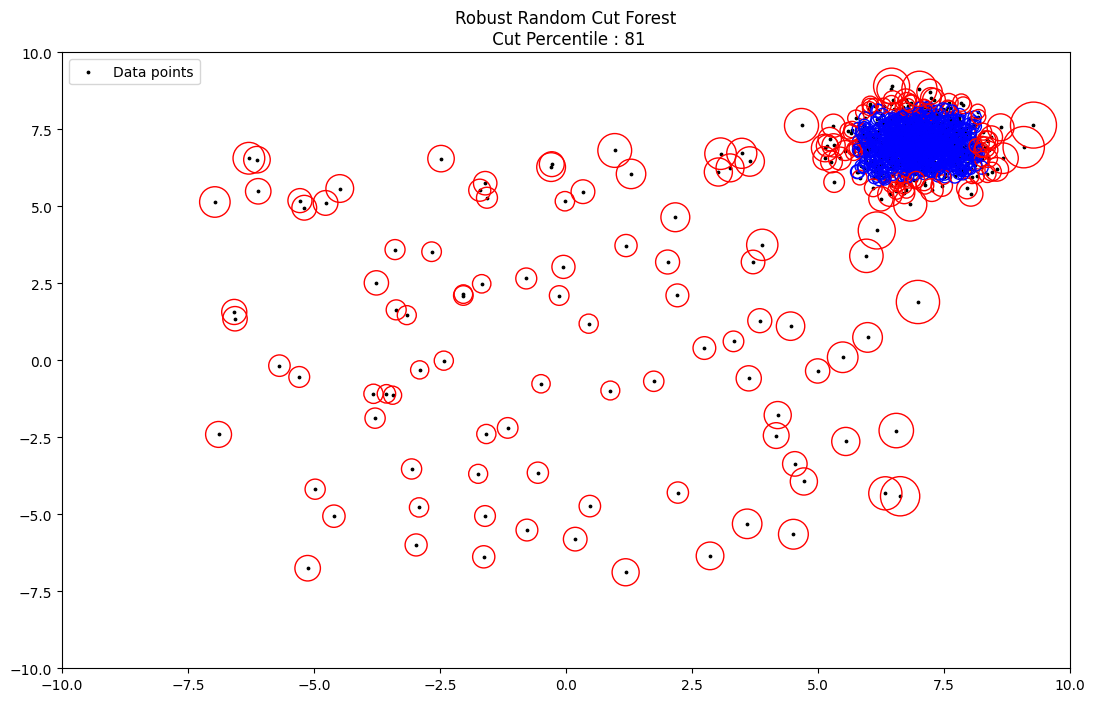

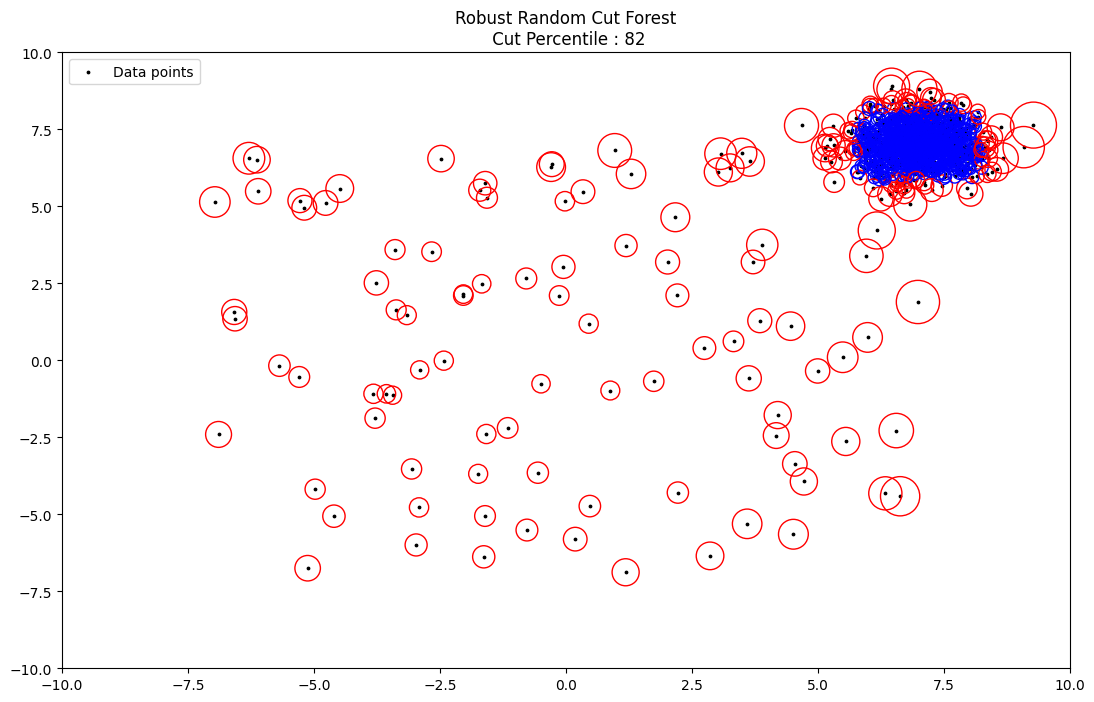

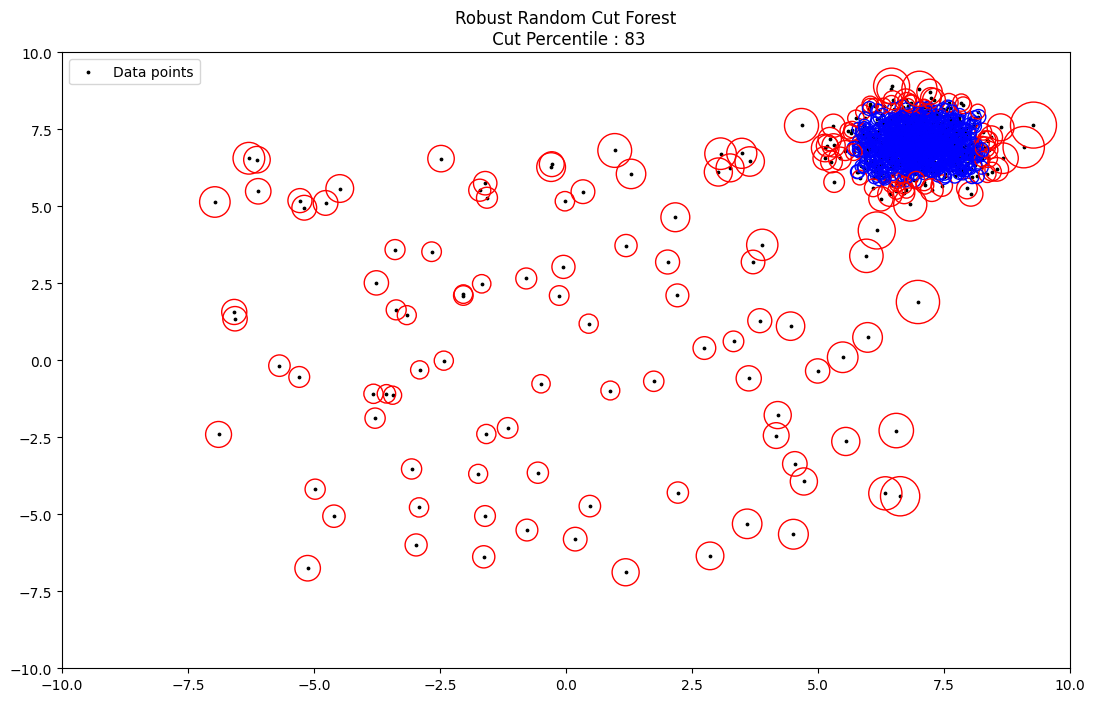

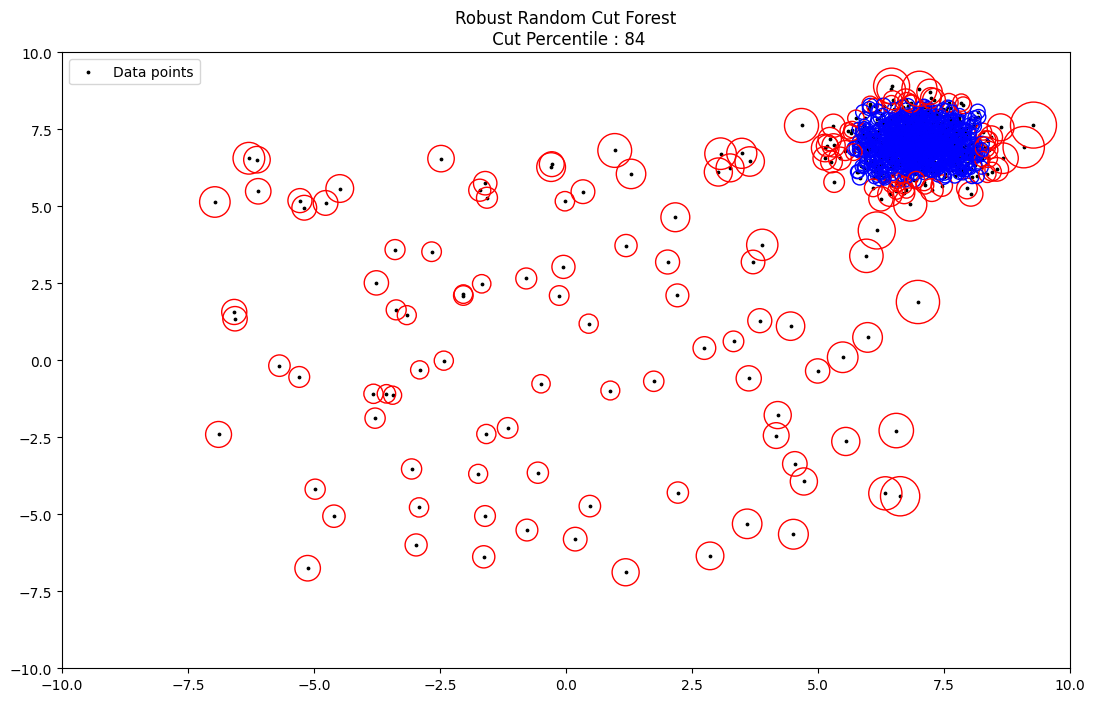

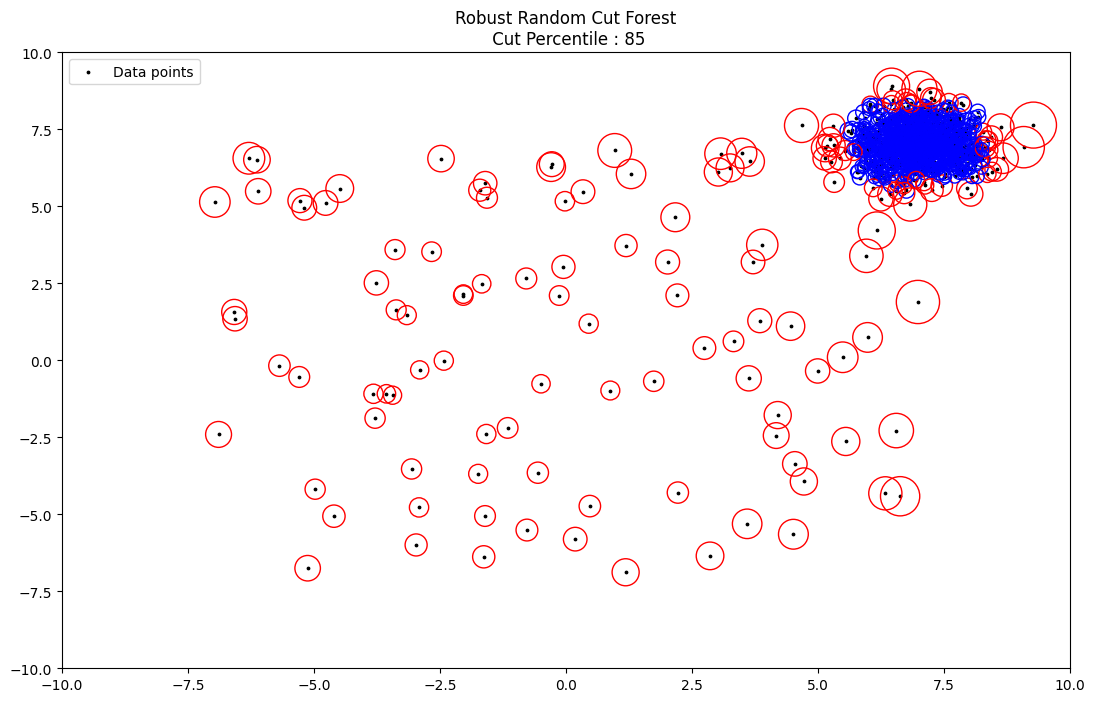

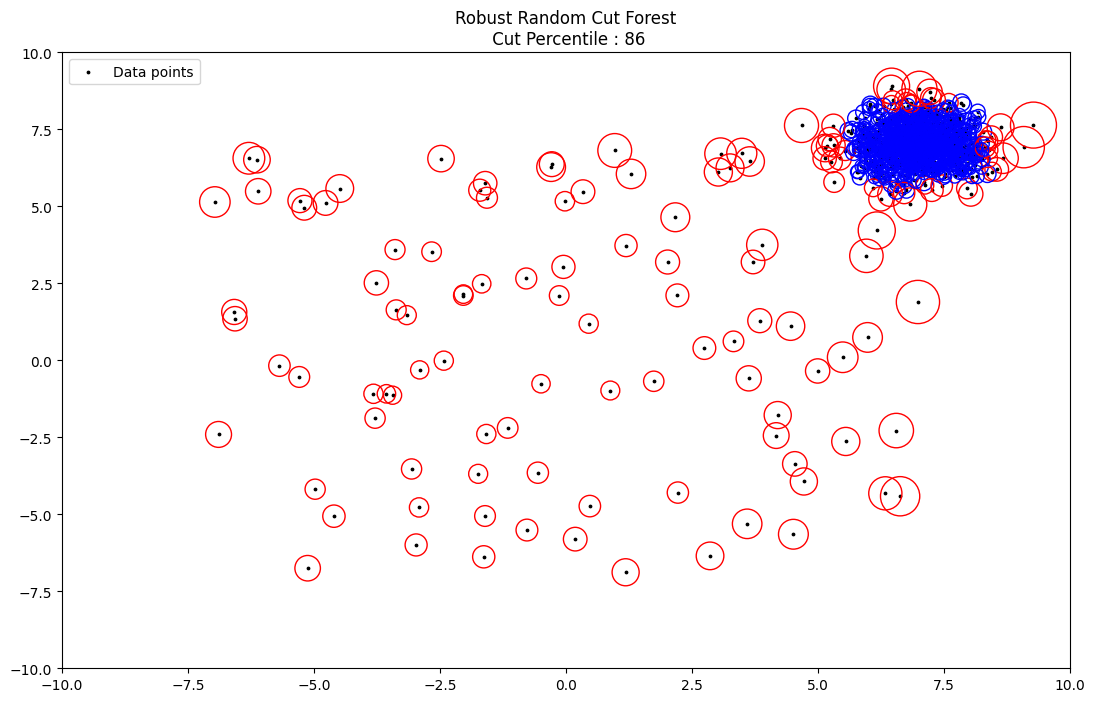

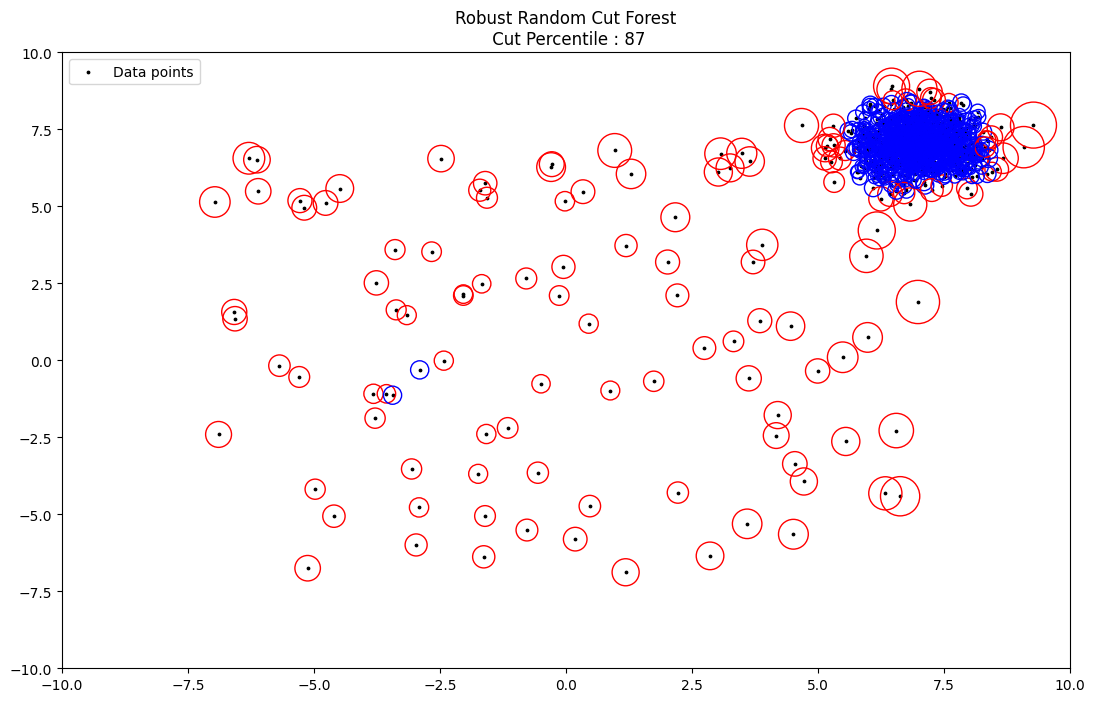

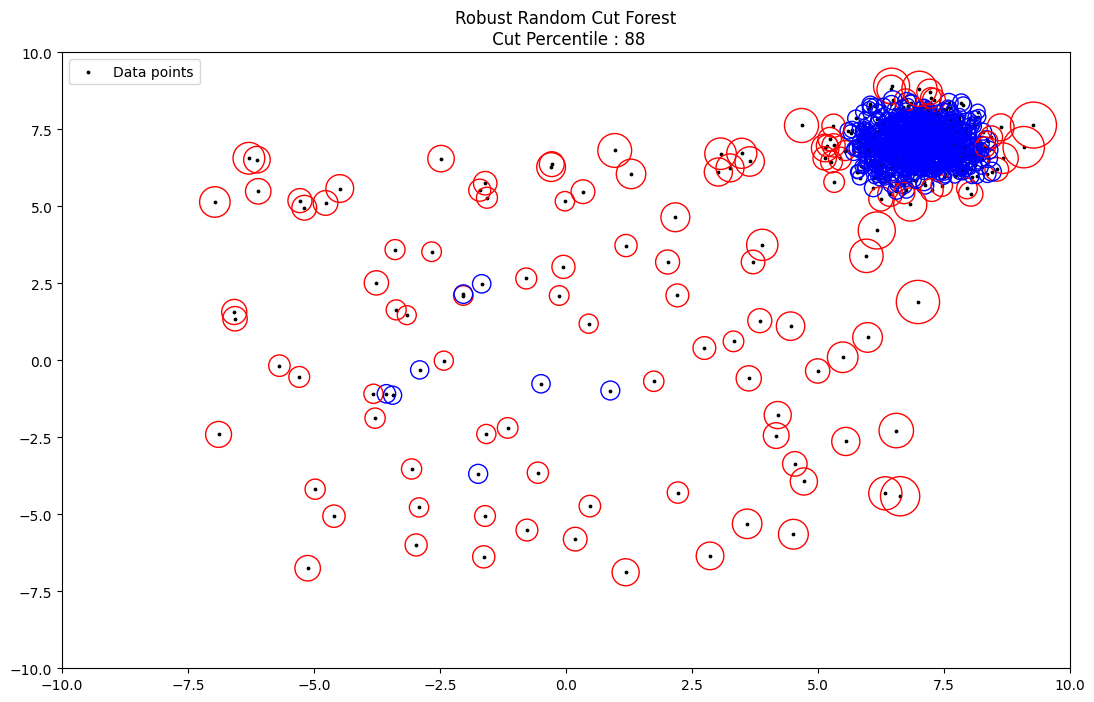

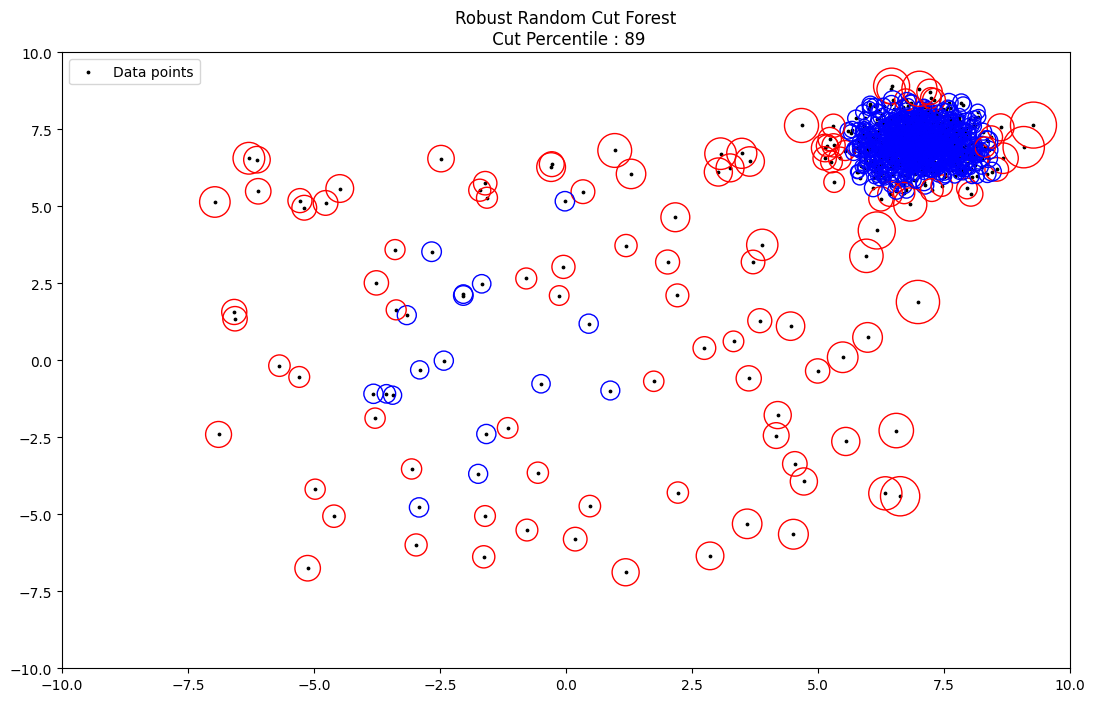

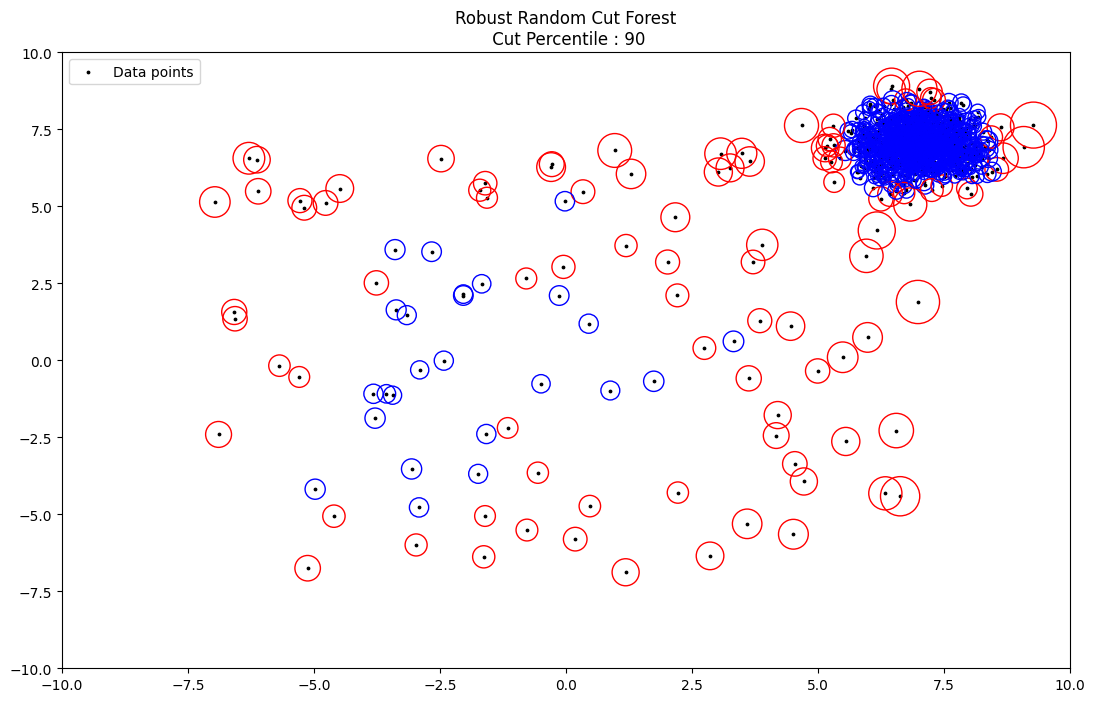

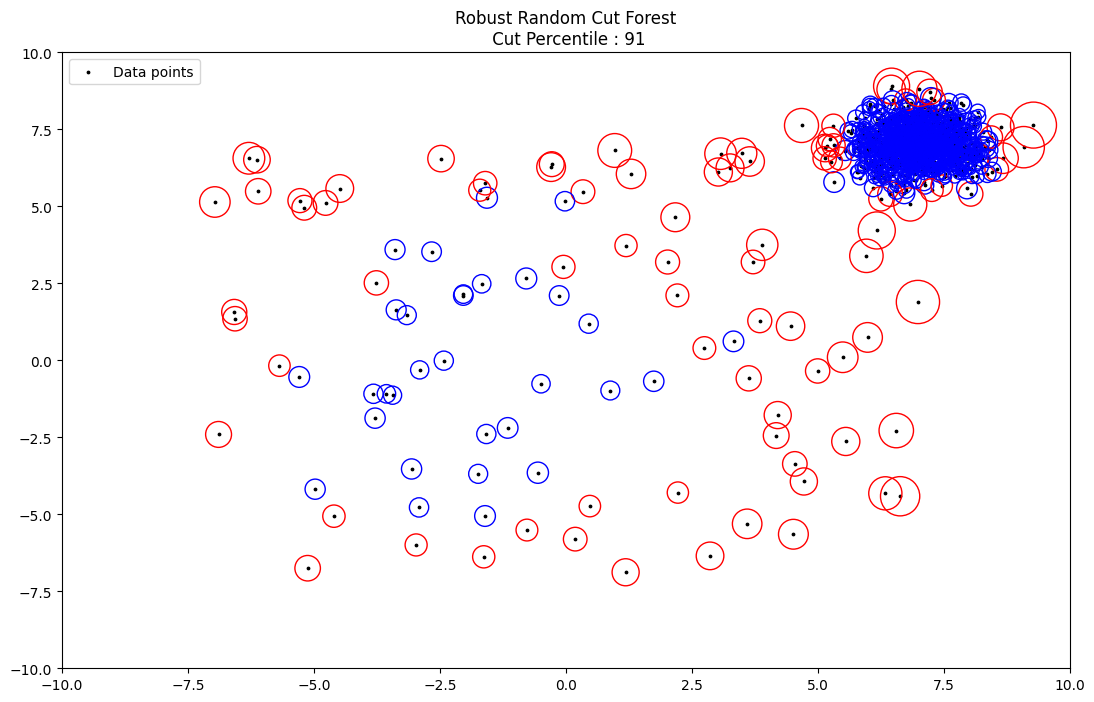

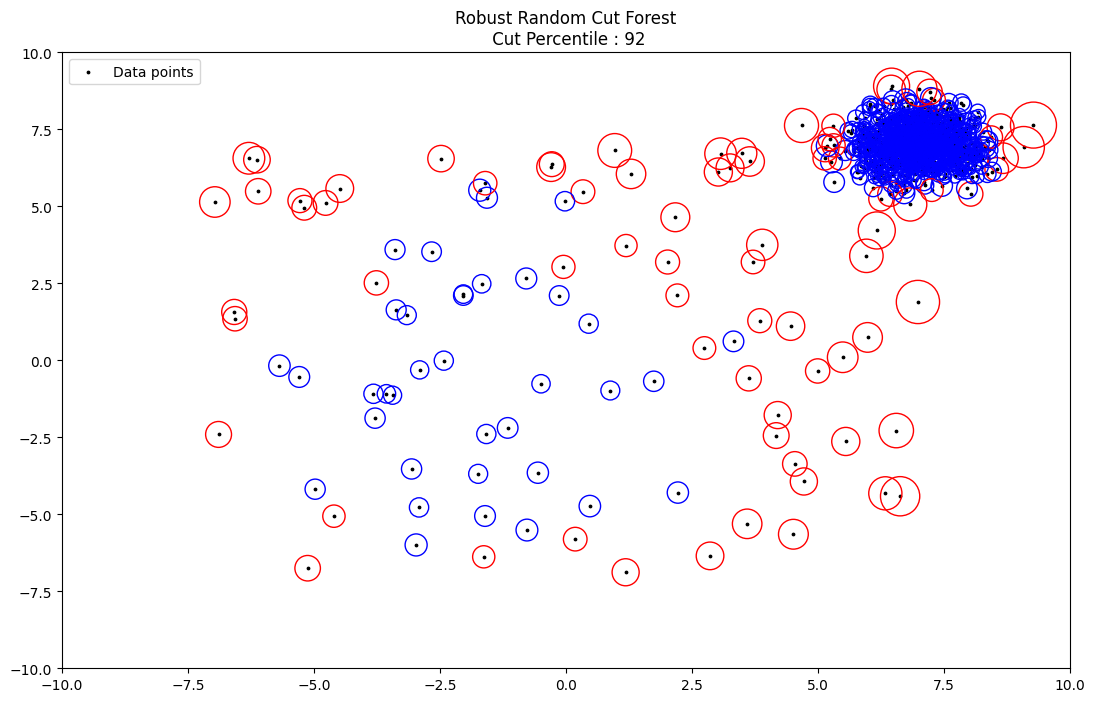

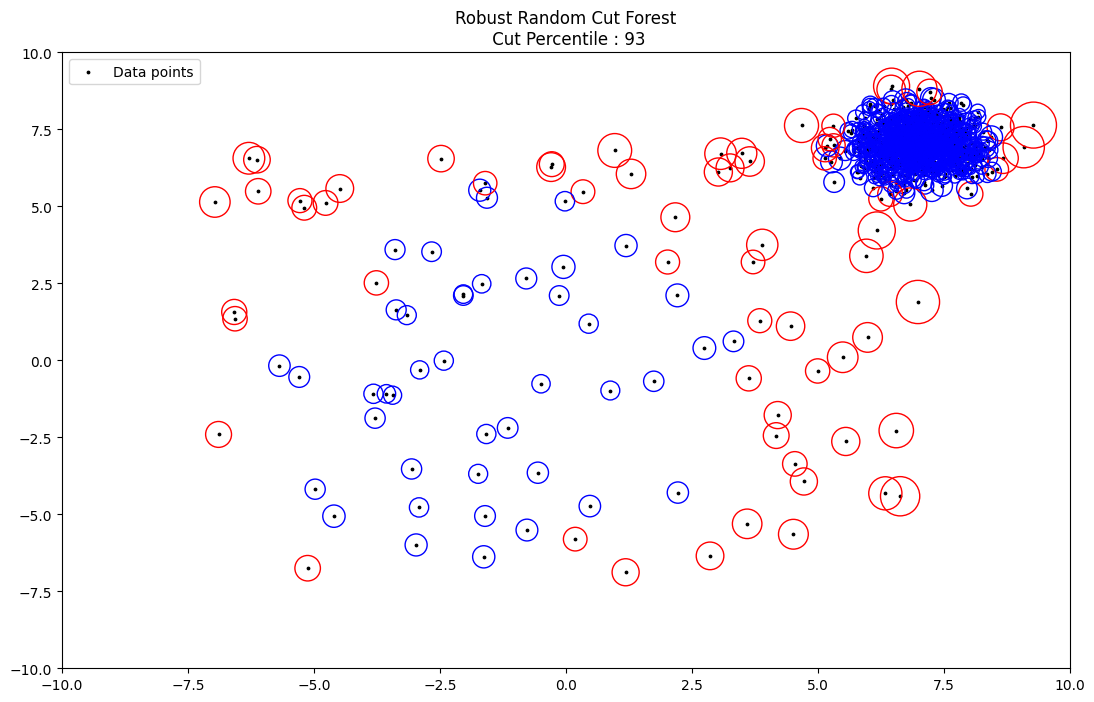

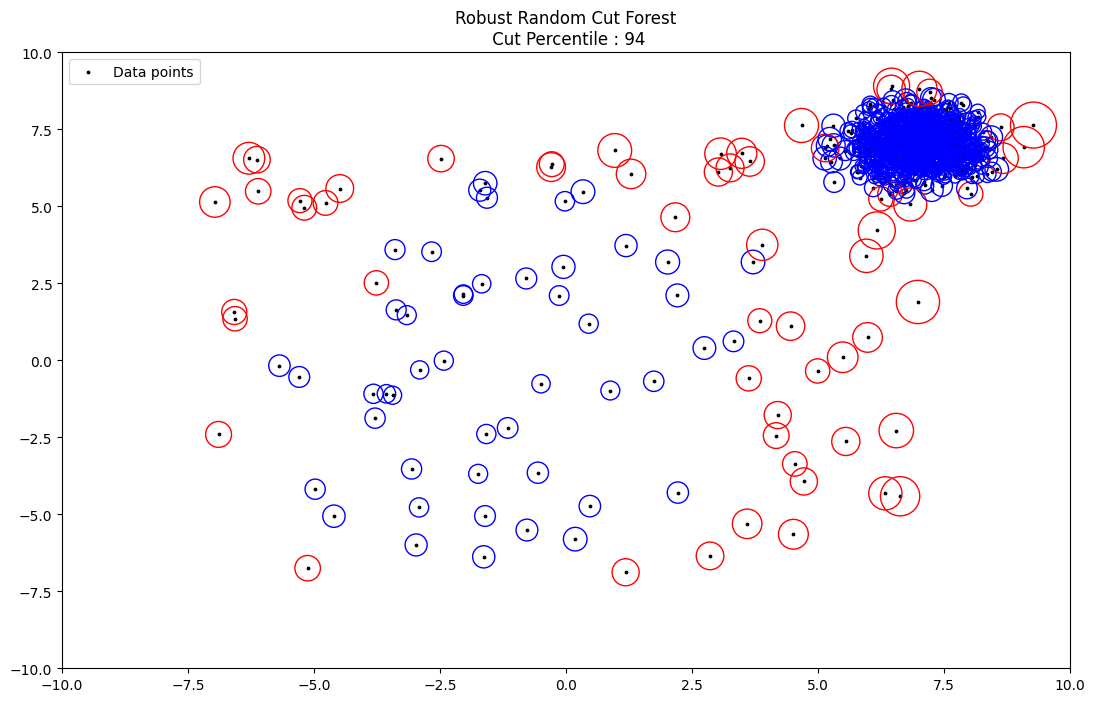

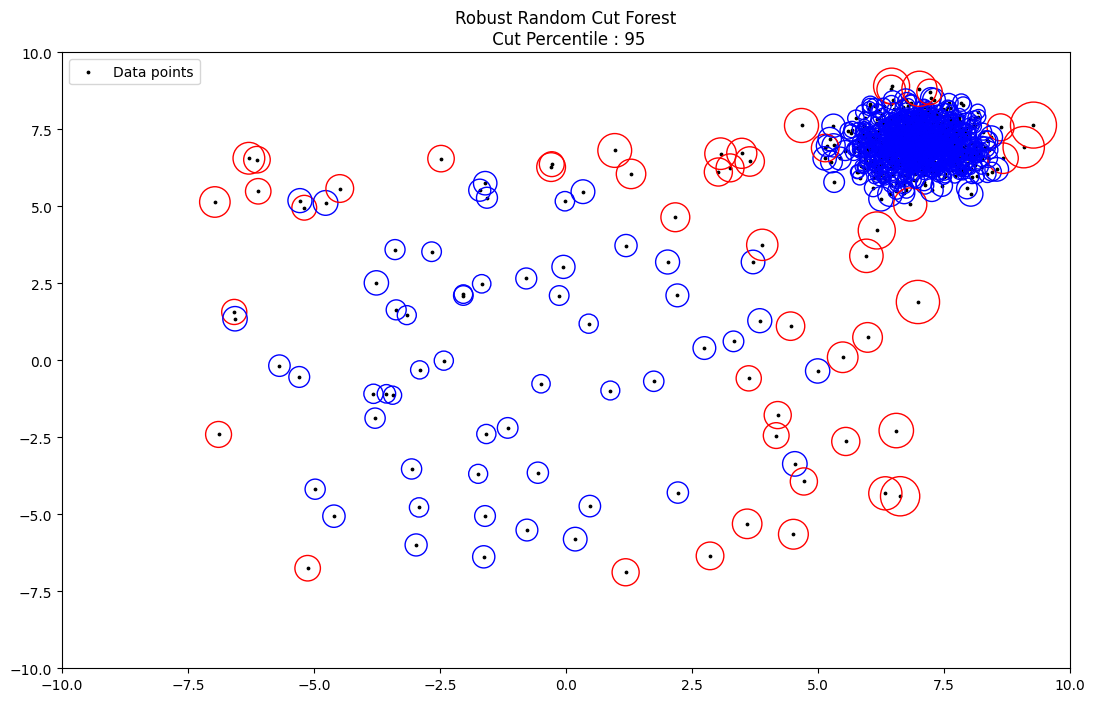

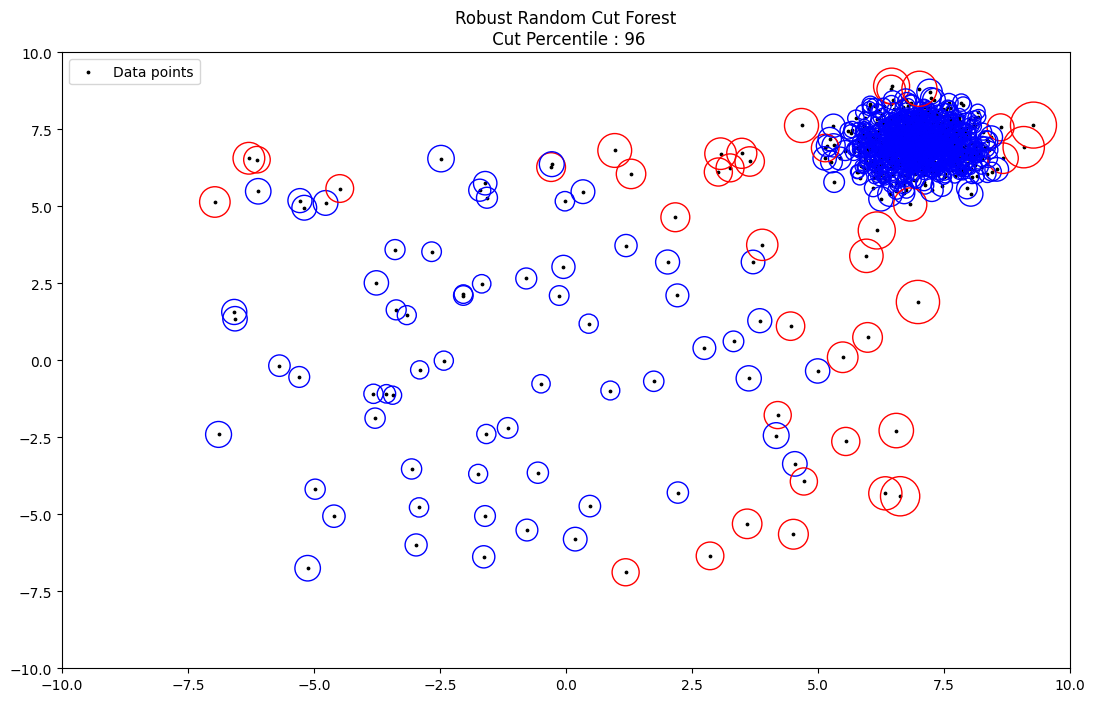

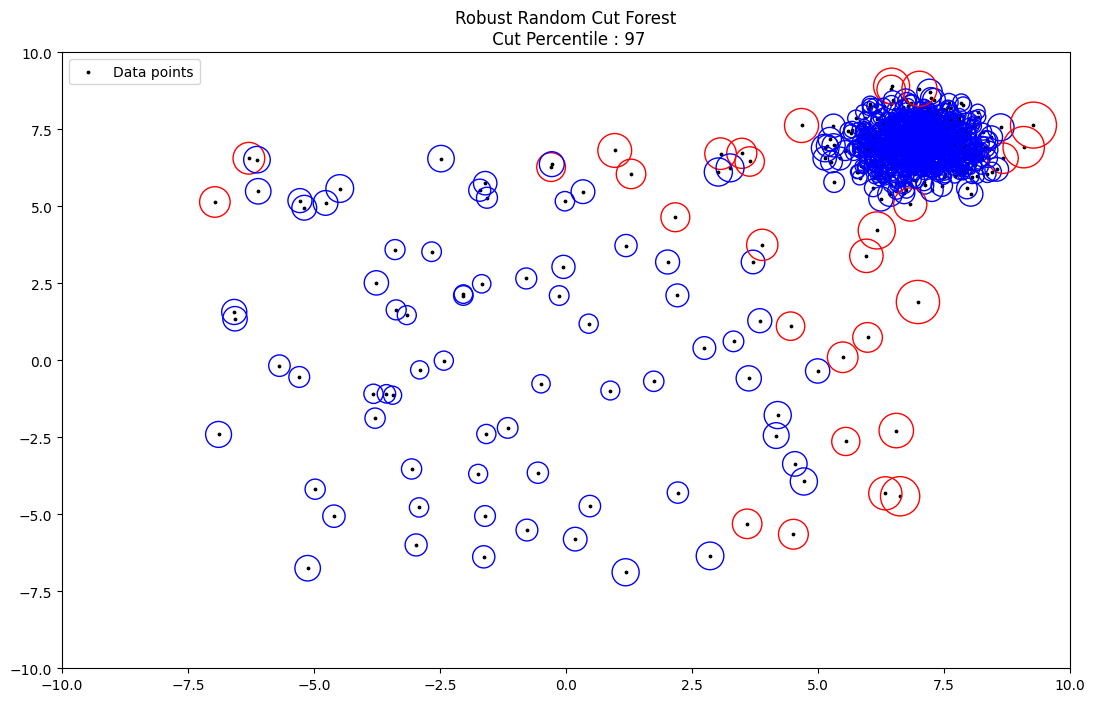

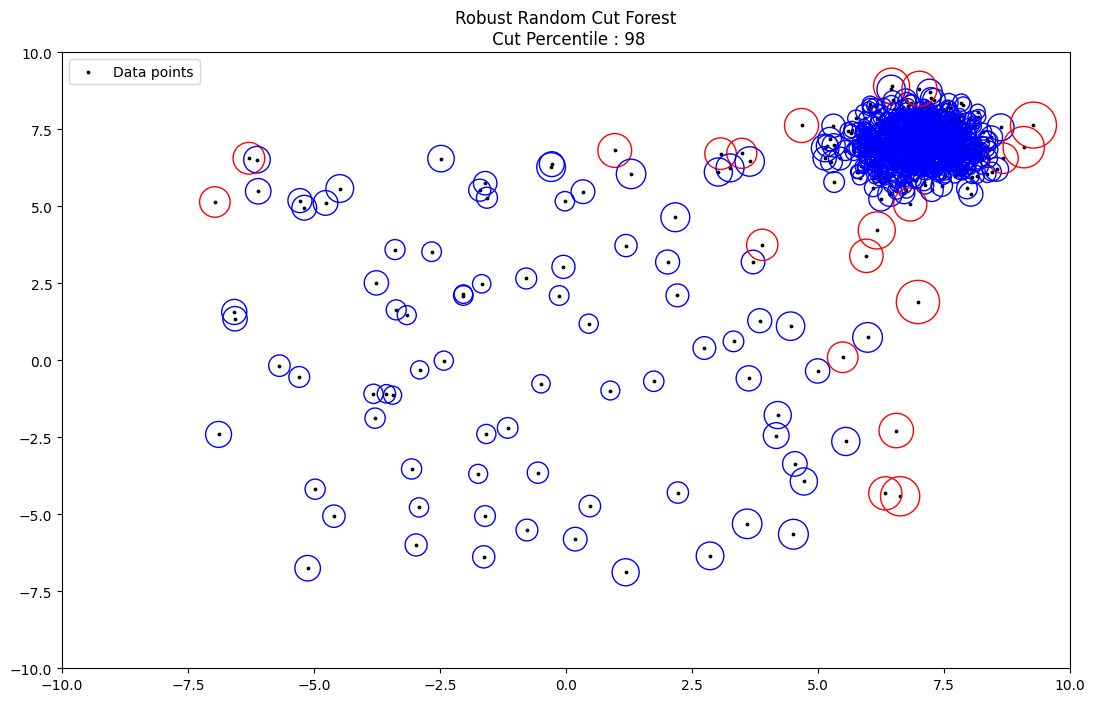

In [11]:
for p in range(80,99):
    plt.figure(figsize=(13,8))
    plt.title("Robust Random Cut Forest\n Cut Percentile : {}".format(p))
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
    # plot circles with radius proportional to the outlier scores
    radius = avg_codisp

    for i in range(df.shape[0]):
        if radius[i] >= np.percentile(radius, p):
                plt.scatter(
                df.iloc[i, 0],
                df.iloc[i, 1],
                s=10 * radius[i],
                edgecolors="r",
                facecolors="none",
                #label="Outlier scores",
            )
        elif radius[i] < np.percentile(radius, p):
                plt.scatter(
                df.iloc[i, 0],
                df.iloc[i, 1],
                s=10 * radius[i],
                edgecolors="b",
                facecolors="none",
                #label="Outlier scores",
            )

    plt.axis("tight")
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    #plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc="upper left")
    #legend.legendHandles[0]._sizes = [10]
    #legend.legendHandles[1]._sizes = [20]
    plt.show()